# Joint Kinetics

I cant follow the kinetics in the paper below so here I work to derive my own.

**Disclaimer \#1** *I am trained electrical engineer with a software, signal processing, and systems focus.  That said, I have more 3D math experience than most. I look forward to an expert telling me where I went wrong.*

**Disclaimer \#2** *Likely there is a systematic way of working through this and some open source package where you describe a geometry and the joint angles, etc. just spit out.  I really look forward to someone pointing this out to me!*

## Anatomy

Here is a picture of the joint:

<div>
    <img src="photos/wrist_assembled.jpg" width=200 height=200 />
    <img src="photos/wrist_joint_schematic.png" width=200 height=200 />
</div>

This is a parallel actuated joint.  The thing consists of (what I think are called) 3 kinetic chains.  Each chain consists of 3 joints.  The joints are enumerated n-c where n is the number 1 to 3 and c is the chain 1 to 3.  All these joints are rotational about a single axis.  The joint angle is specified as the variable $q$.  For example, $q_{31}$ is the joint angle of the 3 joint in chain 1.

Joint 1 is actuated (or active) and driven by a servo motor.  The joint revolves around the vertical axis passing through the center of the effector platform.

Joint 2 is passive.  The joint's axis is 60 degrees from the Earth plane and passes through the center point of the effector platform.

Joint 3 is passive.  The joint's axis is on the platform plane and passes through the platform's center point.  The actual platform might be offset in the platform's z-axis from the center point.

For this analysis we define 2 reference frames centered at the platforms center point.  Reference frame 0 ($RF_0$) is fixed to Earth and reference frame 1 ($RF_1$) fixed to the platform.  The rotation 0 to 1 ($R_{01}$) rotates from $RF_0$ to $RF_1$ by angles about the $RF_0$'s axes.  These angles are $\theta_x$, $\theta_y$, and $\theta_z$.

## Kenematics

### Kenetic goals

The goal is to given a tilt vector $[\theta_x, \theta_y, \theta_z]^T$ to spit out the servo commands that achieve the given tilt vector.  Sure their fancy things to do after that point, e.g. speed, power, reinforcement learning, ... focus! So ...

$$
x = f^{-1}(y)
$$

This translates into:

$$
\begin{bmatrix} s_{1} \\ s_{2} \\ s_{3} \end{bmatrix}
= \frac{T_{spur}}{T_{pinion}} \cdot
\begin{bmatrix} q_{11} \\ q_{12} \\ q_{13} \end{bmatrix}
$$

For convenience we define chain 1 as the chain whose joint 3 axis is coincident with $RF_0$'s y-axis.  The other joints will be dealt with seperately as a 120° transformation.

### Variable Definitions


|Variable|Units|Descriptions|
|--------|-----|------------|
|$q_{31}$  | angle| angle around passive joint 3 y axis|
|$q_{11}$ | angle | angle around active joint 1 z axis|
| e_z | vector | Earth up $e_z = \begin{bmatrix}0 & 0 & 1\end{bmatrix}^T$ in $RF_0$|
|$j3$ | position| joint 3 positional vector (from origin)|
|$j3_{\{1\}}$| position | j3 in $RF_1$ or $\begin{bmatrix} 0 & y_3 & 0 \end{bmatrix}^T$|
|$j2$ | position | joint 2 positional vector (from origin) |
|$Tab$ | transform | Homogenous Transformation Matrix {a}->{b}|
|$T32$ | transform | Joint 3 to joint 2 in neutral position ($q_{31}=0$) |


### Joint 3

Let $R_{01}$ be the rotation matrix $R(\theta_x, \theta_y, \theta_z)$ which rotates $RF_0$ to $RF_1$.  To specify $e_z$ in $RF_1$'s coordinates we use:

$$
e_{z\{1\}} = R_{01}^T e_{z\{0\}}
$$

So you are sitting on a tilted platform and you look Earth up along a unit vector. $e_{z\{1\}}$ is that unit vector in your coordinates.


<img src="photos/wrist_rf_1_with_ez.png" width=100 height=100 />

Defining the components of that vector as $e_z = \begin{bmatrix} x_{ez} & x_{ey} & z_{ez} \end{bmatrix}^T$ gives $q_{31}$ as:

$$
q_{31} = tan^{-1} \frac{z_{ez\{1\}}}{x_{ez\{1\}}}
$$

### Joint 1 (and Joint 2)

Given $q_{31}$ and the fixed link joining joint 3 and joint2, we should be able to apply a series of rotations and displacements (i.e. homogenous transformations matrices) to get $j2$ as displacement vector in $RF_0$.  This the chain of operations:

<img src="photos/wrist_joint_3_to_joint_2_chain.png" height=100 />

We get:

$$
j2 = T_{32} T_{q31} T_{01} j3_{1}
$$

Note that $T_{q31}$ and $T_{01}$ are only rotational transformations.

Here's a view down the z-axis at $j2$:

<img src="photos/wrist_j2_looking_down_z_axis.png" width=100 height=100 />

So with $q_11(0)$ the zero position...

$$
q_{11} = tan^{-1} \frac{j2_x}{j2y} - q_{11}(0)
$$

And as mentioned above:

$$
s_1 = \frac{T_{spur}}{T_{pinion}} \cdot q_{11}
$$

### The other joints

Oh, there are 2 other chains.  To get those, we should be able to rotate the rotation matrix by $+/-120^o$ to resolve the joint angles in friendly coordinates.

## Numerics

### Transforms

In [1]:
import scipy as sp
import numpy as np
%matplotlib widget
np.set_printoptions(precision=1, suppress=True)
from scipy.spatial.transform import Rotation

In [2]:
def htm(rm, dv):
    """
    Function to turn rotation matrix and displacement vector
    into a homogenous transformation matrix.  Handles a list
    or a list of rotation and displacement vectors.
    
    To move a point p_new = T x homogenous coordinate (4).
       Given this order of multimplication:
       1. Rotation ... then
       2. displacement
       
    """
    assert len(rm.shape) == len(dv.shape), f"Dimensions must match d(rm)={len(rm.shape)} but d(dv)={len(dv.shape)}"
    wrm, wdv  = rm, dv
    if len(rm.shape) == 2:
        wrm, wdv = np.array([rm]), np.array([dv])
    M34=np.concatenate([wrm, wdv], axis=2)
    new_row = np.array(M34.shape[0]*[[[0, 0, 0, 1]]])
    M44=np.concatenate([M34, new_row], axis=1)
    if len(rm.shape) == 2:
        M44 = M44[0]
    return M44
    
def rotation_matrix(eulers):
    """
    Returns a rotation matrix (or matrices) from Euler angles
    (or a list/array of Euler angles).
    """
    R01 = Rotation.from_euler('xyz', eulers, degrees=True)
    T01 = R01.as_matrix()
    return T01

### Joint 3 Numeric

OK, so let's rotate the platform's pose to 20° about x and 20° about y.  $q_{31}$ is easy but we can check the math.

In [4]:
R = rotation_matrix(np.array([[20, 20, 0]]))
ez1 = R@np.array([[0, 0, 1]]).T
q31 = np.arctan2(ez1[:, 0, :], ez1[:, 2,:])*180./np.pi
print(f"q31={q31} -- should be 20°")

q31=[[20.]] -- should be 20°


OK, now let's rotate +120° to get clockwise joint angle.  Why +?  Because we want coordinates in the $q33$ y-axis frame. So ...

In [5]:
Rp120 = rotation_matrix(np.array([[0, 0, 120]]))
Rn120 = rotation_matrix(np.array([[0, 0, -120]]))

In [6]:
ez3 = R@Rp120@np.array([[0, 0, 1]]).T
print(f"ez3.T = {ez3[0].T} but ez1.T = {ez1[0].T} -- that is wrong")                  

ez3.T = [[ 0.3 -0.3  0.9]] but ez1.T = [[ 0.3 -0.3  0.9]] -- that is wrong


Order matters here.  The conversion to the $q33$ is y-axis frame has to happen after the platform rotation.

In [7]:
ez3 = Rp120@R@np.array([[0, 0, 1]]).T
ez2 = Rn120@R@np.array([[0, 0, 1]]).T
q33 = np.arctan2(ez3[:, 0, :], ez3[:, 2,:])*180./np.pi
q32 = np.arctan2(ez2[:, 0, :], ez2[:, 2,:])*180./np.pi
print(f"q31={q31} q32={q32} q33={q33}" )

q31=[[20.]] q32=[[-27.4]] q33=[[8.7]]


While we are at it, let's find j3's position in the Earth frame.  Here are joint 3's fixed frame position vectors:

In [8]:
rp = 31.75  # mm - platform radius
j31_1 = np.array([[ 0, rp, 0]]).T
j32_1 = Rp120[0]@j31_1
j33_1 = Rn120[0]@j31_1
print(f"j31_1={j31_1.T} j32_1={j32_1.T} j33_1={j33_1.T}")

j31_1=[[ 0.  31.8  0. ]] j32_1=[[-27.5 -15.9   0. ]] j33_1=[[ 27.5 -15.9   0. ]]


To get the resulting joint position in the Earth frame we multiply by the platform rotation matrix.  Note the dealing with these joint locations as a matrix.

In [9]:
js_1=np.hstack([j31_1, j32_1, j33_1])
js_20=(R@js_1)[0]
print(js_20)

[[  3.7 -27.7  24. ]
 [ 29.8 -14.9 -14.9]
 [ 10.2   4.3 -14.5]]


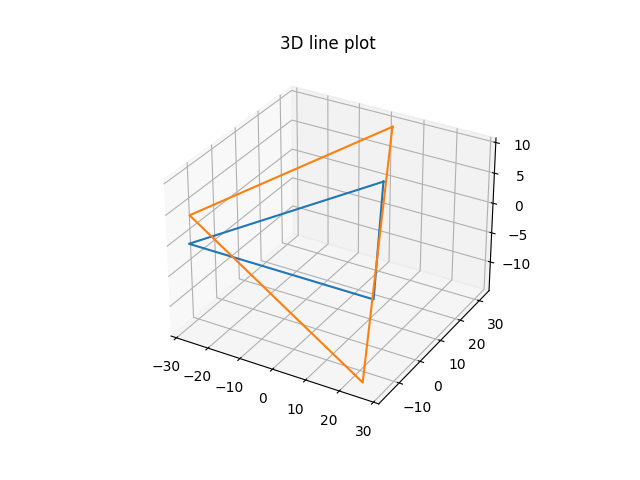

In [10]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

f = plt.figure()
ax = plt.axes(projection='3d')
jsh_1 = np.hstack([js_1,js_1[:,[0]]])
jsh_20 = np.hstack([js_20, js_20[:,[0]]])


ax.plot3D(jsh_1[0,:], jsh_1[1,:], jsh_1[2,:])
ax.plot3D(jsh_20[0,:], jsh_20[1,:], jsh_20[2,:])
ax.set_title('3D line plot')
plt.show()

### Joint 2 Numeric

We have joint 3 location in space by $j3_{\{0\}} = R j3_{\{1\}}$.  We now rotate $J3_{\{0\}}$ by the joint angles and transpose by the arm change.  It looks like we want to do the displayment first then the rotation.  We also need to find the 3D displacement coresponding to the zero joint angle.

In [43]:
ex_j3=np.array([[0, 31.75, 0]]).T
ex_arm_dis=np.array([[38.5, -57.7, 0]]).T
arm_rotation=np.array([0, 50, 0])

In [44]:
R_arm = rotation_matrix(arm_rotation)
hT_32 = htm(R_arm, ex_arm_dis)
print(hT_32)

[[  0.6   0.    0.8  38.5]
 [  0.    1.    0.  -57.7]
 [ -0.8   0.    0.6   0. ]
 [  0.    0.    0.    1. ]]


In [45]:
ht_dv = htm(np.eye(3),ex_arm_dis)
ht_r = htm(R_arm, np.zeros((3,1)))

In [46]:
ot=ht_r@ht_dv

In [51]:
ot@np.vstack([js_1, np.ones((1,3))])

array([[ 24.7,   7.1,  42.4],
       [-26. , -73.6, -73.6],
       [-29.5,  -8.4, -50.6],
       [  1. ,   1. ,   1. ]])

In [48]:
print(j31_1)
hv31_1 = np.vstack([j31_1,[[1.]]])
hT_32@np.vstack([j31_1,[[1.]]])

[[ 0. ]
 [31.8]
 [ 0. ]]


array([[ 38.5],
       [-26. ],
       [  0. ],
       [  1. ]])

In [54]:
ot@hv31_1

array([[ 24.7],
       [-26. ],
       [-29.5],
       [  1. ]])

## References

[Bulgarelli, et. al.](https://journals.sagepub.com/doi/pdf/10.5772/64113) A Low-cost Open Source 3D-Printable Dexterous Anthropomorphic Robotic Hand with a Parallel Spherical Joint Wrist for Sign Languages Reproduction.



In [23]:
tm=M01[0]

In [28]:
ta =np.array(2*[[[0, 0, 0]]])